In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 导入数据

In [2]:
raw_data = pd.read_excel("data_with_one_hot_v2.xlsx")

# 数据预处理

包含原产区的合并、评论数的离散化、价格的离散化

In [3]:
from sklearn import preprocessing


# 编辑合并产区的函数
def refine_origin(origin:str):
    if origin in ["云南", "江苏", "山东", "未知", "北京"]:
        return origin
    return "其他"

raw_data["refined_origin"] = raw_data["origin"].apply(refine_origin)


# 评论离散化
cmt_bins = [-0.1, 0.1, 50, 500, np.inf]
cmt_labels = [0.0, 1.0, 2.0, 3.0] # 为了后期建模方便，分别用0.0，1.0，2.0，3.0代替零评论数、低评论数、中评论数和高评论数
cmt_transformer = preprocessing.FunctionTransformer(
    pd.cut, kw_args={'bins': cmt_bins, 'labels': cmt_labels, 'retbins': False}
)
raw_data["discrete_comment_amount"] = cmt_transformer.fit_transform(raw_data.sale)

bins = [-0.1, 0.1, 50, 500, np.inf]
labels = ['零评论数', '低评论数', '中评论数 ', '高评论数']
transformer = preprocessing.FunctionTransformer(
    pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False}
)
raw_data["discrete_comments_amount_str"] = transformer.fit_transform(raw_data.sale)

# 价格离散化
quantiles = raw_data.avg_price.quantile(q=[0,0.33,0.66,1]).values
price_bins = [quantiles[0]*0.99, quantiles[1], quantiles[2], quantiles[3]*1.01]
price_labels = ["low price", "medium price", "high price"]
price_transformer = preprocessing.FunctionTransformer(
    pd.cut, kw_args={'bins':price_bins, 'labels': price_labels, 'retbins': False}
)
y = price_transformer.fit_transform(raw_data.avg_price)

# 数据属性的可视化

## 离散化后的评论数

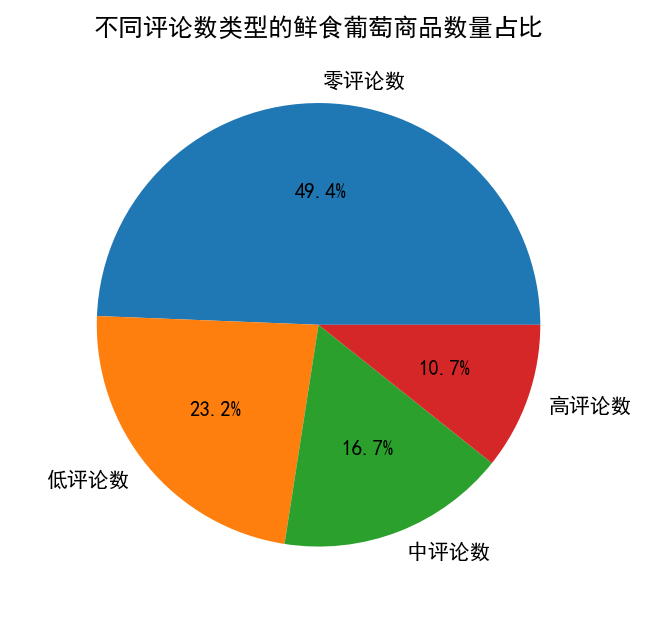

In [4]:
plt.figure(dpi=150)
raw_data.discrete_comments_amount_str.value_counts().rename(" ").plot(kind="pie",title="不同评论数类型的鲜食葡萄商品数量占比",autopct='%1.1f%%')
plt.savefig(r"C:\Users\Herux\OneDrive\2022-2023秋季学期\毕业论文\thesis_pics\comments_piechart.png")
plt.show()

## 均价

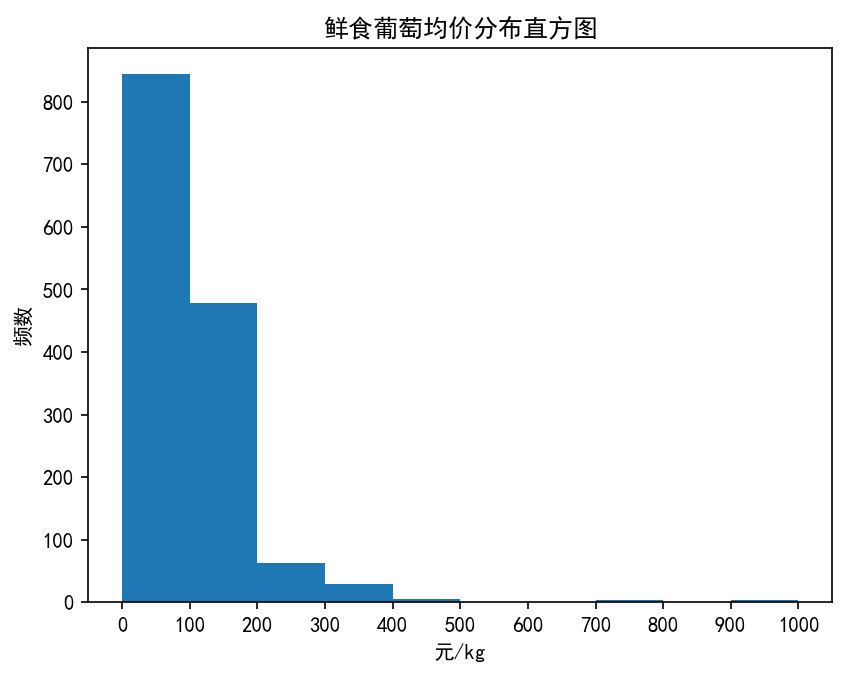

In [5]:
plt.figure(dpi=150)
plt.title("鲜食葡萄均价分布直方图")
plt.ylabel("频数")
plt.xlabel("元/kg")
plt.xticks(np.arange(0,1100,100))
plt.hist(raw_data.avg_price,bins=np.arange(0,1100,100))
# plt.savefig(r"C:\Users\Herux\OneDrive\2022-2023秋季学期\毕业论文\thesis_pics\avgprice_hist.png")
plt.show()

## 净重

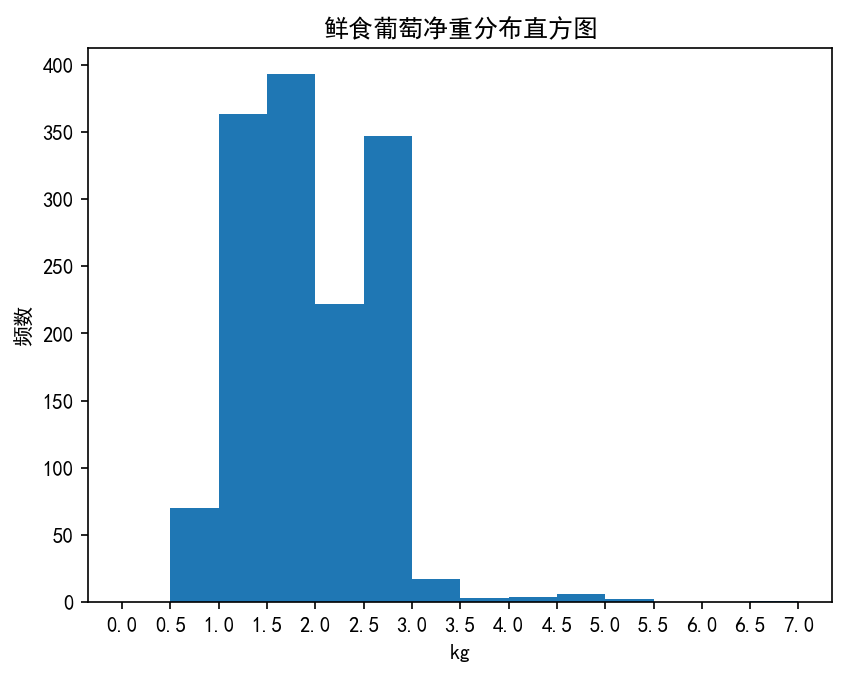

In [6]:
plt.figure(dpi=150)
plt.hist(raw_data.weight,bins=np.arange(0,7.5,0.5))
plt.title("鲜食葡萄净重分布直方图")
plt.ylabel("频数")
plt.xlabel("kg")
plt.xticks(np.arange(0,7.5,0.5))
plt.savefig(r"C:\Users\Herux\OneDrive\2022-2023秋季学期\毕业论文\thesis_pics\weight_hist.png",dpi=400)
plt.show()

## 原产区

In [7]:
raw_data.origin.value_counts().to_excel("origin_value_counts.xlsx")

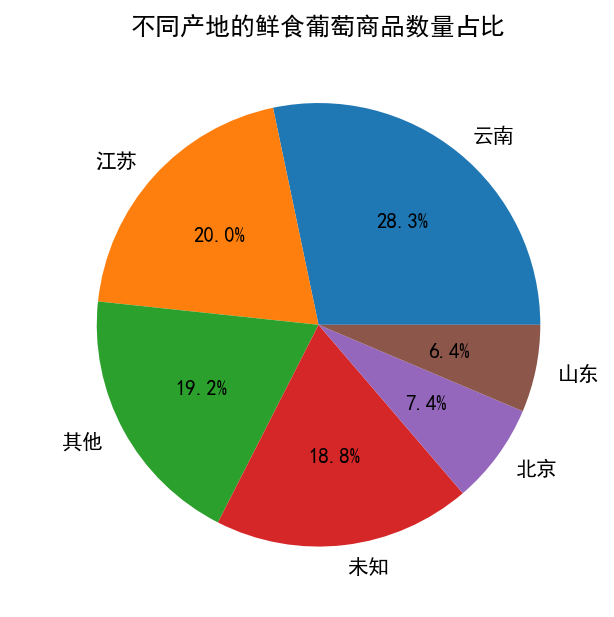

In [8]:
plt.figure(dpi=150)
raw_data.refined_origin.value_counts().rename(" ").plot(kind="pie",title="不同产地的鲜食葡萄商品数量占比",autopct='%1.1f%%')
plt.savefig(r"C:\Users\Herux\OneDrive\2022-2023秋季学期\毕业论文\thesis_pics\refined_origin_piechart.png")
plt.show()

## 精品包装

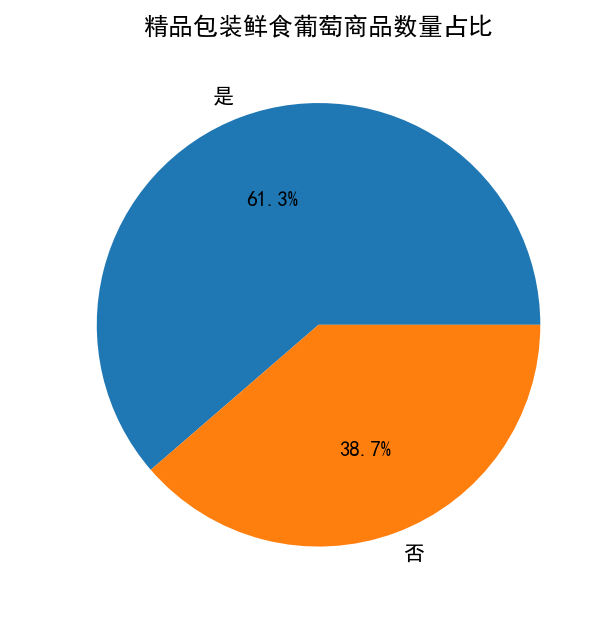

In [9]:
beau_value_counts = raw_data.beau_package_or_not_10.value_counts()
beau_value_counts.index = ["是","否"]
plt.figure(dpi=150)
beau_value_counts.rename(" ").plot(kind='pie',title="精品包装鲜食葡萄商品数量占比",autopct='%1.1f%%')
plt.savefig(r"C:\Users\Herux\OneDrive\2022-2023秋季学期\毕业论文\thesis_pics\beau_piechart.png")
plt.show()

## 商品附加属性

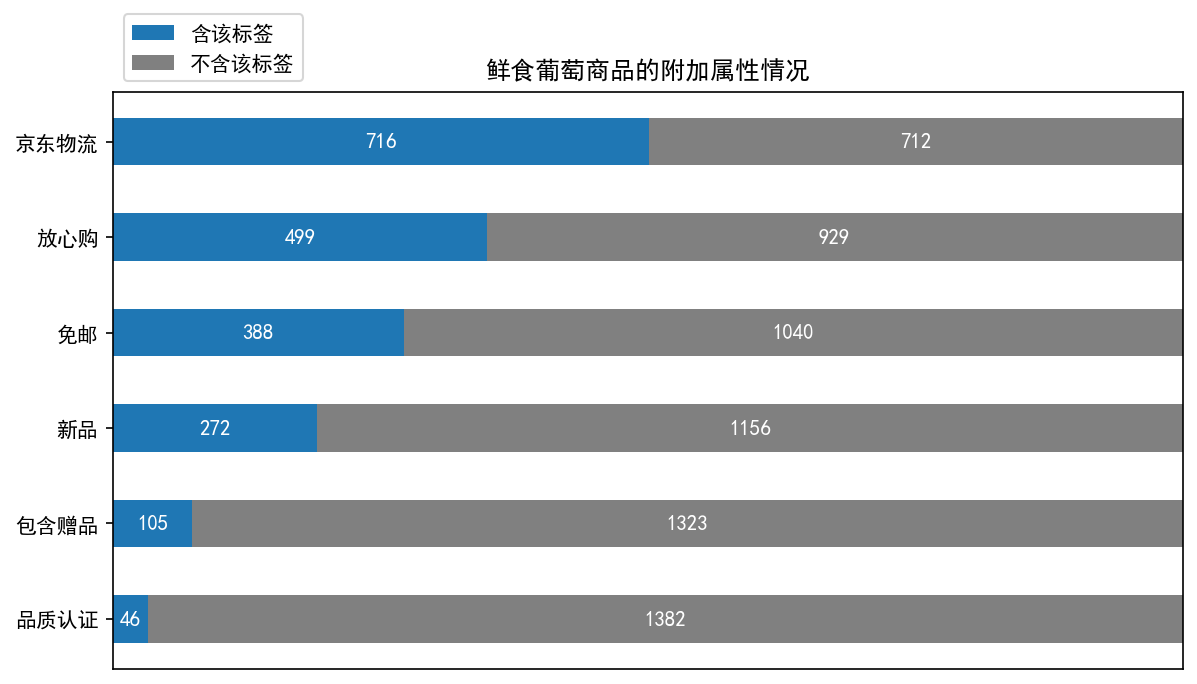

In [10]:
import numpy as np
import matplotlib.pyplot as plt


category_names = ['含该标签', '不含该标签']
results = {
    '京东物流': [716, 1428-716],
    '放心购': [499, 1428-499],
    '免邮': [388, 1428-388],
    '新品': [272, 1428-272],
    '包含赠品': [105, 1428-105],
    '品质认证': [46, 1428-46]
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    # category_colors = plt.colormaps['RdYlGn'](
    #     np.linspace(0.15, 0.85, data.shape[1]))
    category_colors = ["#1f77b4", "grey"]

    fig, ax = plt.subplots(figsize=(9.2, 5), dpi=150)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        #r, g, b, _ = color
        #text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color='white')
    ax.legend(#ncol=len(category_names), 
              bbox_to_anchor=(0, 1),
              loc='lower left'
              )
    ax.set_title("鲜食葡萄商品的附加属性情况")

    return fig, ax


survey(results, category_names)

plt.show()

# 数据集划分

In [11]:
from sklearn.model_selection import train_test_split

X = raw_data[['discrete_comment_amount', 'weight','good_rate', # float data to standardize
                'refined_origin',  # categorial data to impute missing value and then one-hot
                'beau_package_or_not_10','jingdongwuliu', 'fangxingou', # 01
                'mianyou', 'xinping', 'zengpin', 'pinzhirenzheng'# 01
                ]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# 建模前的进一步预处理

包括对数值变量的稳健中心化和对离散变量的独热编码。

In [12]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import numpy as np
from sklearn.pipeline import Pipeline as Pipeline
from sklearn.compose import ColumnTransformer

# 数值变量（净重、好评率）的稳健转换器
numeric_features = ["weight", "good_rate"]
numeric_transformer = Pipeline(
    steps=[("robust_std", RobustScaler(quantile_range=(0.10, 0.90)))]
)

# 类别变量（产区）的独热编码器
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(dtype="int"))
    ]
)

# 用ColumnTransformer将前面两个转换器合并
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("origin", categorical_transformer, ["refined_origin"]),
    ],
    remainder='passthrough', verbose_feature_names_out=False
)

# 鲜食葡萄价格预测模型研究

## 可视化函数

用于输出网格搜索的结果

In [13]:
import matplotlib.pyplot as plt
def plot_cv_results(cv_results:pd.DataFrame, model_name:str):
    plt.figure(figsize=(10,7))
    plt.plot(cv_results.iloc[:,4], cv_results["mean_test_score"])
    best_index = cv_results["rank_test_score"].argmin()
    best_param = cv_results.iloc[best_index, 4]
    best_score = cv_results.loc[best_index, "mean_test_score"] 
    if type(best_param)==str:
        plt.annotate("({},{:.2f},{:.2f})".format(best_param, best_score, cv_results.loc[best_index, "std_test_score"]),
                    xy=(best_param, best_score))
    else:
        plt.annotate("({},{:.2f},{:.2f})".format(best_param, best_score, cv_results.loc[best_index, "std_test_score"]),
                    xy=(best_param, best_score), xytext=(best_param*0.95, best_score))
    plt.ylabel("mean_test_score")
    plt.xlabel(cv_results.columns[4])
    plt.title("cv_results of GridSearchCV for {}".format(model_name))
    plt.show()
    #plt.savefig("{}_cv_results_plot.png".format(model_name),dpi=300)
    plt.clf()

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  GridSearchCV,  KFold
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
cv = KFold(n_splits=4, shuffle=True, random_state=0) # 为了复现，必须要自行设定CV，保证random_state不变，才能保证数据不变。

## KNN

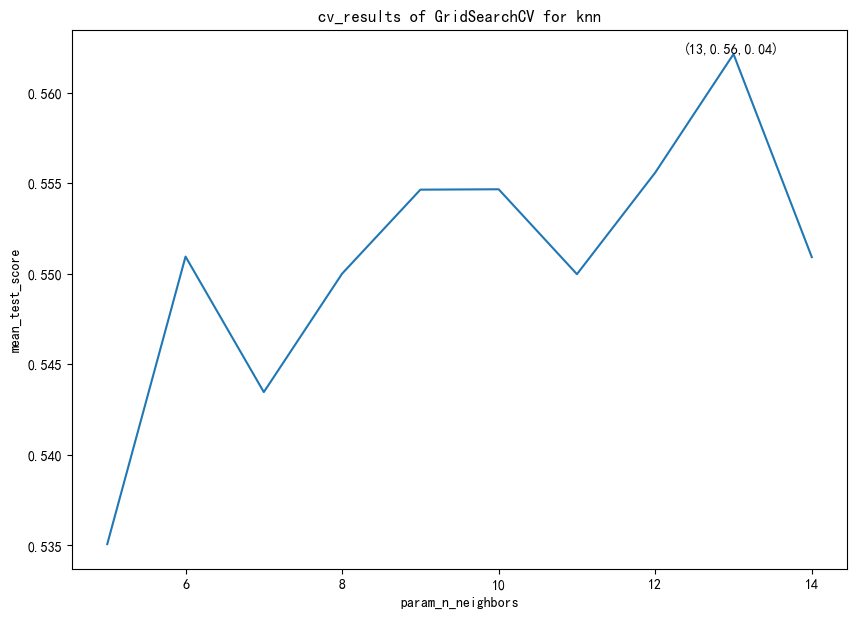

<Figure size 640x480 with 0 Axes>

In [15]:
model_name = 'knn'
    
pipe = Pipeline(
    steps=[
    ("preprocessor",preprocessor),
    ("GridSearch",GridSearchCV(estimator = KNeighborsClassifier(), param_grid={"n_neighbors":np.arange(5,15,1)}, cv=cv, n_jobs=-1))]      
)

y_pred = pipe.fit(X_train, y_train).predict(X_test)

cv_results = pd.DataFrame(pipe[-1].cv_results_)
plot_cv_results(cv_results, model_name)
cv_results.to_excel("{}_cv_results.xlsx".format(model_name))

best_estimator_params = str(pipe[-1].best_estimator_.get_params())
clf_report = classification_report(y_pred=y_pred, y_true=y_test)

In [16]:
print(best_estimator_params)
print(clf_report)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}
              precision    recall  f1-score   support

  high price       0.56      0.62      0.59       124
   low price       0.67      0.69      0.68       127
medium price       0.46      0.39      0.42       106

    accuracy                           0.57       357
   macro avg       0.56      0.56      0.56       357
weighted avg       0.57      0.57      0.57       357



## 逻辑回归

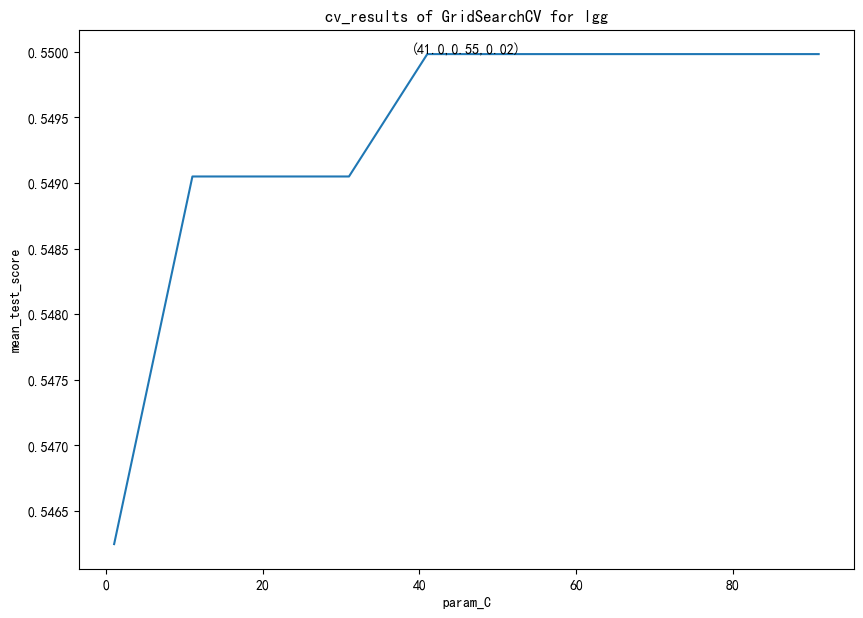

<Figure size 640x480 with 0 Axes>

In [17]:
model_name = 'lgg'
    
pipe = Pipeline(
    steps=[
    ("preprocessor",preprocessor),
    ("GridSearch",GridSearchCV(estimator = LogisticRegression(random_state=15), param_grid={"C":np.arange(1.0,100.0,10.0)}, cv=cv, n_jobs=-1))]      
)

y_pred = pipe.fit(X_train, y_train).predict(X_test)

cv_results = pd.DataFrame(pipe[-1].cv_results_)
plot_cv_results(cv_results, model_name)
#cv_results.to_excel("{}_cv_results.xlsx".format(model_name))

best_estimator_params = str(pipe[-1].best_estimator_.get_params())
clf_report = classification_report(y_pred=y_pred, y_true=y_test)

In [18]:
print(best_estimator_params)
print(clf_report)

{'C': 41.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 15, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

  high price       0.52      0.59      0.55       124
   low price       0.64      0.54      0.59       127
medium price       0.37      0.38      0.37       106

    accuracy                           0.51       357
   macro avg       0.51      0.50      0.50       357
weighted avg       0.52      0.51      0.51       357



## 随机森林

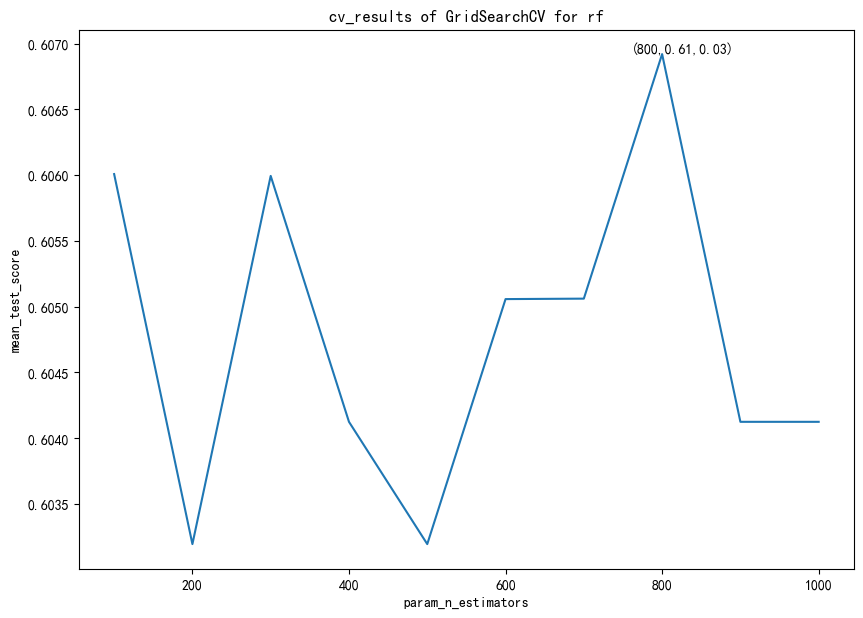

<Figure size 640x480 with 0 Axes>

In [19]:
model_name = 'rf'
    
pipe = Pipeline(
    steps=[
    ("preprocessor",preprocessor),
    ("GridSearch",GridSearchCV(estimator = RandomForestClassifier(random_state=15), param_grid={"n_estimators":np.arange(100,1100,100)}, cv=cv, n_jobs=-1))]      
)

y_pred = pipe.fit(X_train, y_train).predict(X_test)

cv_results = pd.DataFrame(pipe[-1].cv_results_)
plot_cv_results(cv_results, model_name)
#cv_results.to_excel("{}_cv_results.xlsx".format(model_name))

best_estimator_params = str(pipe[-1].best_estimator_.get_params())
clf_report = classification_report(y_pred=y_pred, y_true=y_test)

In [20]:
print(best_estimator_params)
print(clf_report)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 800, 'n_jobs': None, 'oob_score': False, 'random_state': 15, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

  high price       0.59      0.64      0.61       124
   low price       0.71      0.67      0.69       127
medium price       0.48      0.46      0.47       106

    accuracy                           0.60       357
   macro avg       0.59      0.59      0.59       357
weighted avg       0.60      0.60      0.60       357



# T检验

In [21]:
def find_origin_yunnan(origin:str):
    if origin=="云南":
        return 1
    return 0
raw_data["refined_origin_云南"] = raw_data["refined_origin"].apply(find_origin_yunnan)

In [22]:
importance_features_and_labels = raw_data[["weight","good_rate","discrete_comment_amount", "beau_package_or_not_10","jingdongwuliu","mianyou","fangxingou","refined_origin_云南"]].join(pd.DataFrame(y))
importance_features_and_labels["discrete_comment_amount"] = importance_features_and_labels["discrete_comment_amount"].astype(float)
importance_features_and_labels = importance_features_and_labels.rename(axis=1,
                                           mapper={"beau_package_or_not_10":"是否精品包装",
                                            "discrete_comment_amount":"评论数",
                                            "fangxinggou":"是否放心购",
                                            "good_rate":"好评率",
                                            "jingdongwuliu":"是否京东物流",
                                            "mianyou":"是否免邮",
                                            "refined_origin_云南":"原产区是否云南",
                                            "weight":"净重",
                                            "fangxingou":"是否放心购",
                                            "avg_price":"均价"})

In [23]:
importance_features_and_labels.pivot_table(index='均价', aggfunc="mean")

,净重,原产区是否云南,好评率,是否京东物流,是否免邮,是否放心购,是否精品包装,评论数
均价,,,,,,,,
low price,1.947452,0.093418,0.944756,0.382166,0.229299,0.239915,0.596603,0.857749
medium price,1.634004,0.336864,0.958072,0.610169,0.277542,0.351695,0.618644,1.008475
high price,1.522680,0.414433,0.972371,0.511340,0.307216,0.453608,0.624742,0.800000


In [24]:
low_price = importance_features_and_labels[importance_features_and_labels["均价"]=="low price"][["净重","是否精品包装","评论数", "是否放心购","是否京东物流","是否免邮","原产区是否云南","好评率"]]
medium_price = importance_features_and_labels[importance_features_and_labels["均价"]=="medium price"][["净重","是否精品包装","评论数", "是否放心购","是否京东物流","是否免邮","原产区是否云南","好评率"]]
high_price = importance_features_and_labels[importance_features_and_labels["均价"]=="high price"][["净重","是否精品包装","评论数", "是否放心购","是否京东物流","是否免邮","原产区是否云南","好评率"]]

In [25]:
from scipy import stats
t1, p1 = stats.ttest_ind(low_price, medium_price)
t2, p2 = stats.ttest_ind(low_price, high_price)
t3, p3 = stats.ttest_ind(medium_price, high_price)

In [26]:
ttest_results = pd.DataFrame([t1,p1,t2,p2,t3,p3],index=["t stats for low vs medium", "p",\
                                         "t stats for low vs high", "p",\
                                            "t stats for medium vs high", "p"],
                                            columns=["净重", "是否精品包装", "评论数","是否放心购","是否京东物流","是否免邮", "原产区是否云南", "好评率"])
ttest_results

,净重,是否精品包装,评论数,是否放心购,是否京东物流,是否免邮,原产区是否云南,好评率
t stats for low vs medium,7.164677e+00,-0.692535,-2.118029,-3.784724e+00,-7.183598e+00,-1.703704,-9.511488e+00,-1.494684
p,1.573162e-12,0.488772,0.034434,1.636156e-04,1.379855e-12,0.088767,1.519669e-20,0.135332
t stats for low vs high,9.935806e+00,-0.891603,0.885721,-7.106940e+00,-4.045644e+00,-2.724371,-1.220926e+01,-3.091440
p,3.334322e-22,0.372830,0.375991,2.321838e-12,5.639771e-05,0.006560,5.854359e-32,0.002050
t stats for medium vs high,2.528089e+00,-0.194286,3.213299,-3.227142e+00,3.091492e+00,-1.008275,-2.481916e+00,-1.952180
p,1.162875e-02,0.845993,0.001356,1.292888e-03,2.049304e-03,0.313578,1.323881e-02,0.051209
